# 层和块
任何一个层和神经网络,都应该是Module的一个子类

In [54]:
import os;import os.path as osp;import json ;from glob import glob;from rich import print;from munch import Munch
from torch import nn
from torch.nn import functional as F

net = nn.Sequential(nn.Linear(20,256),nn.ReLU(),nn.Linear(256,10))

X = torch.rand(2,20)
net(X)

tensor([[-0.0712, -0.1278, -0.0124, -0.0046, -0.0456, -0.0139, -0.1957, -0.0197,
          0.1245, -0.0387],
        [-0.0109, -0.1360, -0.1159, -0.0752, -0.0908,  0.0179, -0.2747,  0.0150,
          0.0976, -0.0964]], grad_fn=<AddmmBackward0>)

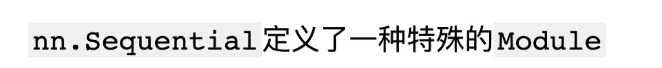

## 1.1自定义块

In [50]:
class MLP(nn.Module):
    # 用模型参数声明层。这里，我们声明两个全连接的层
    def __init__(self):
        # 调用MLP的父类Module的构造函数来执行必要的初始化。
        # 这样，在类实例化时也可以指定其他函数参数，例如模型参数params（稍后将介绍）
        super().__init__()
        self.hidden = nn.Linear(20, 256)  # 隐藏层
        self.out = nn.Linear(256, 10)  # 输出层

    # 定义模型的前向传播，即如何根据输入X返回所需的模型输出
    def forward(self, X):
        # 注意，这里我们使用ReLU的函数版本，其在nn.functional模块中定义。
        return self.out(F.relu(self.hidden(X)))
net = MLP()
net(X)

tensor([[-0.1208,  0.1283, -0.0124,  0.0689,  0.1006, -0.0526, -0.0510, -0.2414,
          0.0081,  0.2493],
        [-0.0427,  0.0598, -0.0760, -0.0204,  0.1236,  0.0425, -0.0236, -0.2165,
         -0.0287,  0.1801]], grad_fn=<AddmmBackward0>)

## 1.2顺序块

In [73]:
class MySequential(nn.Module):
    def __init__(self, *args):
        super().__init__()
        for idx, module in enumerate(args):
            # 这里，module是Module子类的一个实例。我们把它保存在'Module'类的成员
            # 变量_modules中。module的类型是OrderedDict
            self._modules[str(idx)] = module

    def forward(self, X):
        # OrderedDict保证了按照成员添加的顺序遍历它们
        for block in self._modules.values():
            X = block(X)
        return X

net = MySequential(nn.Linear(20,256),nn.ReLU(),nn.Linear(256,10))
net(X)

tensor([[ 0.0727,  0.1931, -0.1105, -0.1423,  0.0856, -0.0414, -0.1736, -0.1213,
         -0.1151, -0.2333],
        [ 0.1012,  0.2380, -0.0851, -0.1491,  0.1256, -0.0456, -0.0644, -0.1208,
         -0.1536, -0.1855]], grad_fn=<AddmmBackward0>)

## 1.3在正向传播中执行代码

In [74]:
class FixedHiddenMLP(nn.Module):
    def __init__(self):
        super().__init__()
        # 不计算梯度的随机权重参数。因此其在训练期间保持不变
        self.rand_weight = torch.rand((20, 20), requires_grad=False)
        self.linear = nn.Linear(20, 20)

    def forward(self, X):
        X = self.linear(X)
        # 使用创建的常量参数以及relu和mm函数
        X = F.relu(torch.mm(X, self.rand_weight) + 1)
        # 复用全连接层。这相当于两个全连接层共享参数
        X = self.linear(X)
        # 控制流
        while X.abs().sum() > 1:
            X /= 2
        return X.sum()
    
net = FixedHiddenMLP()
net(X)

tensor(-0.1863, grad_fn=<SumBackward0>)

## 1.4混合搭配各种组合块方法

In [75]:
class NestMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(20, 64), nn.ReLU(),
                                 nn.Linear(64, 32), nn.ReLU())
        self.linear = nn.Linear(32, 16)

    def forward(self, X):
        return self.linear(self.net(X))

chimera = nn.Sequential(NestMLP(), nn.Linear(16, 20), FixedHiddenMLP())
chimera(X)

tensor(-0.4144, grad_fn=<SumBackward0>)